# Let's get started! ⚡

In [248]:
## import Module

# Exploratory Data Analysis
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Data Preprocessing
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.base import TransformerMixin
from sklearn.model_selection import train_test_split

# LightGBM Training
import lightgbm
from lightgbm import LGBMClassifier

# Data Reading

In [249]:
# 데이터 읽어오기
df_train = pd.read_csv('./train.csv')
df_test = pd.read_csv('./test.csv')

In [250]:
# 헤드 확인
df_train.head()

PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S

In [251]:
# 데이터의 컬럼 수 확인
print(df_train.shape, df_test.shape)

(891, 12) (418, 11)


In [252]:
# 컬럼별 타입과 Null값 확인
print(df_train.info())
print()
print(df_test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pc

# Data Preprocessing ⚙️🧹

### 결측치 채우기 전 전처리 함수 선언

In [253]:
# 'PassengerId' 컬럼 드랍 (상관관계 X)
# 제출할 때는 컬럼 다시 추가해줘야 합니다.
def drop_PassengerId(df_train):
    df_train = df_train.drop(columns=['PassengerId'])
    return df_train

In [254]:
# 'Name' 컬럼에서 'honorific_title' 컬럼 생성하기
# 의미있는 호칭(Mr, Mrs, Miss, Master)을 추출하는 과정입니다.

# 'honorific_title' 생성하는 함수
def get_honorific_title(name):
    top4_titles = ('Mr', 'Mrs', 'Miss', 'Master')

    # top4 호칭으로 바꿔줄 소수 여성 호칭
    female_titles_to_Mrs = ('Mme', 'the Countess', 'Dona', 'Lady')
    female_titles_to_Miss = ('Mlle', 'Ms')

    # top4 호칭으로 바꿔줄 소수 남성 호칭
    male_titles_to_Mr = ('Major', 'Col', 'Capt', 'Don', 'Sir', 'Jonkheer', 'Rev')

    # 예 : "Braund, Mr. Owen Harris"에서 'Mr' 추출
    # '.'(마침표) 기준으로 이름을 자르고, ','(콤마) 제거
    honorific_title = name.split('.')[0].split(', ')[-1]

    # 호칭에 따라 변환해서 리턴
    if honorific_title in top4_titles:
        return honorific_title
    elif honorific_title in female_titles_to_Mrs:
        return 'Mrs'
    elif honorific_title in female_titles_to_Miss:
        return 'Miss'
    elif honorific_title in male_titles_to_Mr:
        return 'Mr'
    else:
        return honorific_title

In [255]:
# 남녀 양쪽 전부 존재하는 호칭 처리 함수
def processing_honorific_title_on_both_side(df):
    # 조건 설정
    title_on_both_side = ['Dr']
    cond_mr = (df['Sex'] == 'male') & (df['honorific_title'].isin(title_on_both_side))
    cond_mrs = (df['Sex'] == 'female') & (df['honorific_title'].isin(title_on_both_side))
    
    # 치환
    df.loc[cond_mr, 'honorific_title'] = 'Mr'
    df.loc[cond_mrs, 'honorific_title'] = 'Mrs'
    
    return df

In [256]:
# 새 피쳐로 사용할 컬럼 'honorific_title' 생성
def make_honorific_title(df_train, df_test):
    df_train['honorific_title'] = df_train['Name'].map(get_honorific_title)
    df_test['honorific_title'] = df_test['Name'].map(get_honorific_title)

    # 남녀 양쪽 전부 존재하는 호칭에 대한 처리
    df_train = processing_honorific_title_on_both_side(df_train)
    df_test = processing_honorific_title_on_both_side(df_test)

    return df_train, df_test

In [257]:
# 원래 컬럼 'Name'를 드랍
def drop_Name(df_train, df_test):
    df_train = df_train.drop(columns=['Name'])
    df_test = df_test.drop(columns=['Name'])
    
    return df_train, df_test

In [258]:
# 'Family' 컬럼 계산해서 생성
def make_Family_column(df_train, df_test):
    df_train['Family'] = df_train['SibSp'].astype(int) + df_train['Parch'].astype(int) + 1
    df_test['Family'] = df_test['SibSp'].astype(int) + df_test['Parch'].astype(int) + 1
    
    return df_train, df_test

In [259]:
# 'Famliy' 컬럼 레이블 인코딩
def label_encoding_Family(df_train, df_test):
    df_train['Family'] = df_train['Family'].map(
        lambda f : str(f) if f < 3 else '>=3'
    )

    df_test['Family'] = df_test['Family'].map(
        lambda f : str(f) if f < 3 else '>=3'
    )
    
    return df_train, df_test

In [260]:
# 'SibSp' 컬럼 드랍
def drop_SibSp(df_train, df_test):
    df_train = df_train.drop(columns=['SibSp'])
    df_test = df_test.drop(columns=['SibSp'])
    
    return df_train, df_test

In [261]:
# 'Parch' 컬럼 드랍
def drop_Parch(df_train, df_test):
    df_train = df_train.drop(columns=['Parch'])
    df_test = df_test.drop(columns=['Parch'])
    
    return df_train, df_test

In [262]:
# 'Ticket' 컬럼 드랍 (의미를 찾을수 없음)
def drop_Ticket(df_train, df_test):
    df_train = df_train.drop(columns=['Ticket'])
    df_test = df_test.drop(columns=['Ticket'])
    
    return df_train, df_test

In [263]:
# 'Cabin' 컬럼 U로 채우고 매핑
def mapping_Cabin(df_train, df_test):
    # Cabin 빈칸 채우기
    df_train['Cabin'] = df_train['Cabin'].fillna('Unknown')
    df_test['Cabin'] = df_test['Cabin'].fillna('Unknown')

    # Cabin의 머리글자를 추출하고 매핑하기 위한 함수 생성
    cabin_mapping = {
        cabin[0]: idx for idx, cabin in enumerate(sorted(set(cabin[0] for cabin in df_train['Cabin'].unique())))
    }

    # 매핑 적용
    df_train['Cabin'] = df_train['Cabin'].map(lambda x : cabin_mapping[x[0]])
    df_test['Cabin'] = df_test['Cabin'].map(lambda x : cabin_mapping[x[0]])
    
    return df_train, df_test

### Imputer Class 선언

In [264]:
# 'Age' 결측치 채우는 클래스
class AgeImputer(
    SimpleImputer, TransformerMixin
):
    """
    Age Imputer from 'honorific_title' column.

    There are four honorific titles: Mr, Mrs, Miss, Master.
    We proved that these groups have statistically different
    mean Ages (Independent T-tests).

    Imputation strategy:
        - fit:  compute the mean Age for each honorifit title
            Compute the mean Age for those who do not have title
        - transform:  if Age is missing for a passenger, if it has
            honorific title, the mean Age for that honorific title
            will be assigned. Else, the mean age for those who do
            not have title will be assigned.
    """

    def __init__(self) -> None:
        """
        Initialize an AgeImputer instance
        """

        # Initialize the parent Sklearn classes
        super().__init__()
        # Define the mappig {title_: mean Age for title_}
        self.title2age = {}
        # Define the mean age of those people with no title
        self.no_title_mean_age = None
        self.is_fitted = False


    def fit(self, X: pd.DataFrame, y=None):
        """
        Fits the 'title2age' and 'honorific_title' using 'X'.

        'X' is assumed to be Training Data (not Test Data!)
        'X' is assumed to be a non-empty data frame with
            (at least) the columns 'Age' and 'honorific_title'
        """

        df_groupby = df_train.groupby(
            by='honorific_title'
        ).agg({'Age': 'mean'})
        self.title2age = df_groupby.to_dict()['Age']

        if X['honorific_title'].isna().sum() == 0:
            self.no_title_mean_age = X['Age'].mean()
        else:
            self.no_title_mean_age = X.loc[
                X['honorific_title'].isna(), 'Age'
            ].mean()
        self.is_fitted = True
        return self


    def transform(self, X: pd.DataFrame, y=None) -> pd.DataFrame:
        """
        Transform 'X' by imputing the missing values of 'Age'

        'X' is assumed to be Training Data (not Test Data!)
        'X' is assumed to be a non-empty data frame with
            (at least) the columns 'Age' and 'honorific_title'
        """

        if not self.is_fitted:
            raise Exception("Call the 'fit' method first")

        X_out = X.copy(deep=True)
        missing_age_idx = X.loc[X['Age'].isna(), :].index
        age_col_idx = np.where(X.columns == 'Age')[0][0]

        for idx in missing_age_idx:

            # get the honorific_title of the 'idx' row
            title = X.loc[idx,'honorific_title']

            if title in self.title2age:
                X_out.loc[idx, 'Age'] = self.title2age[title]
            else:
                X_out.loc[idx, 'Age'] = self.no_title_mean_age

        return X_out['Age'].to_frame()

In [265]:
# Create three imputers : 결측치 채우는 함수를 imputer라고 합니다.
age_imputer = AgeImputer().set_output(transform='pandas')

fare_imputer = SimpleImputer(
    strategy='median'
).set_output(transform='pandas')

embarked_imputer = SimpleImputer(
    strategy='most_frequent'
).set_output(transform='pandas')


# Create a general imputer (for all the variables)
imputer = ColumnTransformer(
    transformers=[
        ('age_imp', age_imputer, ['Age', 'honorific_title']),
        ('fare_imp', fare_imputer, ['Fare']),
        ('embarked_imp', embarked_imputer, ['Embarked'])
    ],
    remainder='passthrough', # 나머지는 놔둔다.
    verbose_feature_names_out=False
).set_output(transform='pandas')

In [266]:
# 'honorific_title' 한정 원핫 인코딩(나이 결측치 채우는 데 필요)
def make_honorific_title_dummy(df_train, df_test):
    df_train['dummy_honorific_title'] = df_train['honorific_title']
    df_train = pd.get_dummies(
          data=df_train
        , columns=['dummy_honorific_title']
        , prefix=''
        , prefix_sep=''
        , dummy_na=False  # Null 컬럼은 복사하지 않는다.
        , drop_first=False  # Top4 honorific titles 행은 전부 복사
        , dtype=int
    )
    
    df_test['dummy_honorific_title'] = df_test['honorific_title']
    df_test = pd.get_dummies(
          data=df_test
        , columns=['dummy_honorific_title']
        , prefix=''
        , prefix_sep=''
        , dummy_na=False
        , drop_first=False
        , dtype=int
    )
    
    return df_train, df_test

### 결측치 채우기 전 전처리 함수 모음

In [267]:
# 결측치 채우기 전 전처리 함수 모음
def before_impute_preprocessing(df_train, df_test):
    # 바로 드랍하는 컬럼들 드랍
    df_train = drop_PassengerId(df_train)
    df_train, df_test = drop_Ticket(df_train, df_test)
    
    # 호칭 만들고 'Name' 컬럼 드랍
    df_train, df_test = make_honorific_title(df_train, df_test)
    df_train, df_test = drop_Name(df_train, df_test)
    
    # 'Cabin' 컬럼 매핑
    df_train, df_test = mapping_Cabin(df_train, df_test)
    
    # 'Family' 컬럼 만들고 레이블 인코딩
    df_train, df_test = make_Family_column(df_train, df_test)
    df_train, df_test = label_encoding_Family(df_train, df_test)
    
    # 'Family' 컬럼 만든 후 필요없는 컬럼 드랍
    df_train, df_test = drop_SibSp(df_train, df_test)
    df_train, df_test = drop_Parch(df_train, df_test)
    
    # honorific_title의 더미 컬럼 생성
    df_train, df_test = make_honorific_title_dummy(df_train, df_test)
       
    return df_train, df_test

In [268]:
# 결측치 채우기 전 전처리 함수 실행
df_train, df_test = before_impute_preprocessing(df_train, df_test)

### 결측치 채우기

In [269]:
# 결측치 채우기
df_train = pd.DataFrame(
      imputer.fit_transform(df_train)
    , columns=df_train.columns
)

df_test = pd.DataFrame(
      imputer.fit_transform(df_test)
    , columns=df_test.columns
)

### 결측치 채운 후 전처리 함수 선언

In [270]:
# 'Age' 컬럼 레이블 인코딩
def label_encoding_Age(df_train, df_test):
    for dataset in [df_train, df_test]:
        dataset.loc[dataset['Age'] <= 19, 'Age'] = 0
        dataset.loc[(dataset['Age'] > 19) & (dataset['Age'] <= 25), 'Age'] = 1
        dataset.loc[(dataset['Age'] > 25) & (dataset['Age'] <= 31.8), 'Age'] = 2
        dataset.loc[(dataset['Age'] > 31.8) & (dataset['Age'] <= 41), 'Age'] = 3
        dataset.loc[dataset['Age'] > 41, 'Age'] = 4
        
        dataset['Age'] = dataset['Age'].astype(int)    
    
    return df_train, df_test

In [271]:
# 'Fare' 컬럼 레이블 인코딩
def label_encoding_Fare(df_train, df_test):
    for dataset in [df_train, df_test]:
        dataset.loc[dataset['Fare'] <= 7.91, 'Fare'] = 0
        dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
        dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare'] = 2
        dataset.loc[dataset['Fare'] > 31, 'Fare'] = 3
        dataset['Fare'] = dataset['Fare'].astype(int)
        
    return df_train, df_test

In [272]:
# 원핫 인코딩
def one_hot_encoder(df_train, df_test):
  df_train = pd.get_dummies(
        data=df_train
      , dummy_na=False
      , drop_first=False
      , dtype=int
  ).drop(columns='honorific_title')

  df_test = pd.get_dummies(
        data=df_test
      , dummy_na=False
      , drop_first=False
      , dtype=int
  ).drop(columns='honorific_title')
  
  return df_train, df_test

### 결측치 채운 후 전처리 함수 모음

In [273]:
# 결측치 채운 후 전처리 함수 모음
def after_impute_preprocessing(df_train, df_test):
    # 'Age' 컬럼 레이블 인코딩
    df_train, df_test = label_encoding_Age(df_train, df_test)
    
    # 'Fare' 컬럼 레이블 인코딩
    df_train, df_test = label_encoding_Fare(df_train, df_test)    
    # 원핫 인코딩
    df_train, df_test = one_hot_encoder(df_train, df_test)
    
    return df_train, df_test

In [274]:
# 두번째 전처리 함수 호출
df_train, df_test = after_impute_preprocessing(df_train, df_test)

## 피어슨 계수 행렬 시각화

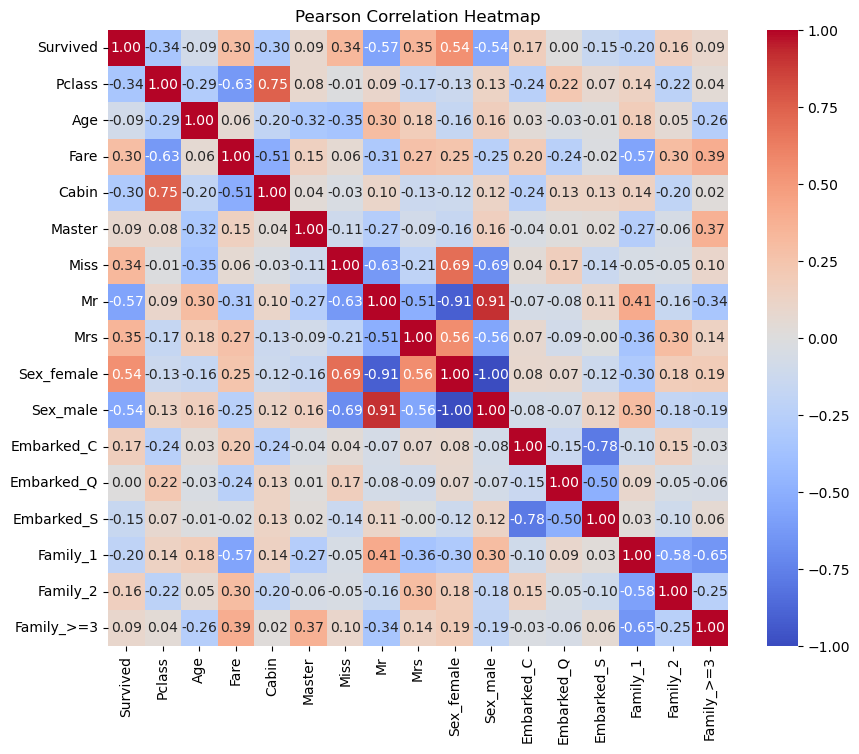

In [275]:
# 피어슨 계수 행렬 시각화
corr_matrix = pd.get_dummies(df_train).corr(method='pearson')

plt.figure(figsize=(10, 8))
sns.heatmap(
    corr_matrix, annot=True, cmap='coolwarm', fmt=".2f"
)
plt.title("Pearson Correlation Heatmap")
plt.show()

# LightGBM Training 🏋️‍♂️

In [276]:
# 학습데이터의 데이터와 답 분리
X_train = df_train.drop(columns=['Survived'])
y_train = df_train['Survived']

# 테스트데이터 생성
X_test = df_test.drop(columns='PassengerId')

In [277]:
# 학습데이터로 검증데이터 추출
X_tr, X_val, y_tr, y_val = train_test_split(
      X_train
    , y_train
    , test_size=0.1
    , random_state=42
)

In [278]:
# 학습데이터와 검증데이터 세팅
evals = [(X_tr, y_tr), (X_val, y_val)]

In [279]:
lgbm = LGBMClassifier(
      n_estimators=400
    , learning_rate=0.01
)

# Submission File 🏆🎯

In [280]:
# 위에서 찾은 최적의 hyperparameters set을 이용한 최고의 모델 생성

In [281]:
# 생성한 모델로 학습
# 학습
lgbm.fit(
     X_tr, y_tr
    # , early_stopping_rounds=50
    , callbacks=[lightgbm.early_stopping(stopping_rounds=50)]
    , eval_metric='logloss'
    , eval_set=evals
)

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[211]	training's binary_logloss: 0.370951	valid_1's binary_logloss: 0.401763


LGBMClassifier(learning_rate=0.01, n_estimators=400)

In [282]:
# 테스트데이터 넣어서 예측
pred = lgbm.predict(X_test)

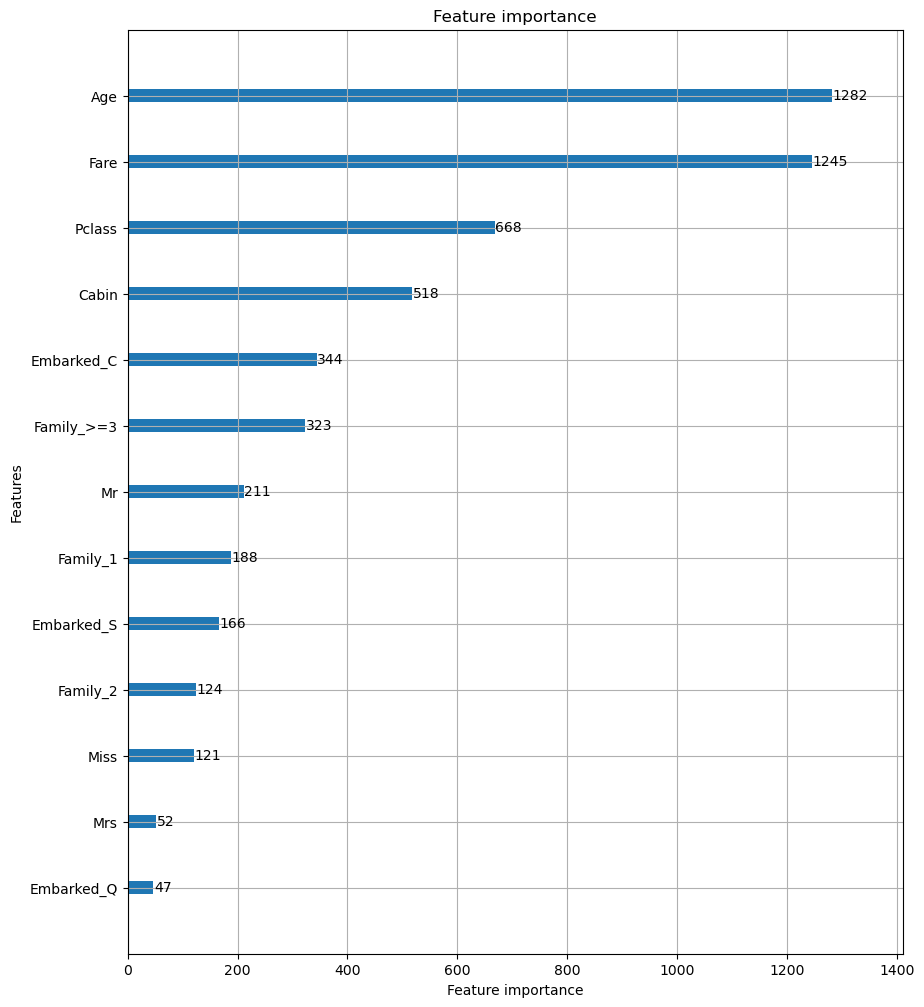

In [283]:
# 피처 중요도 시각화
from lightgbm import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize=(10,12))
plot_importance(lgbm, ax=ax)
plt.show()

In [284]:
# 제출파일 준비: PassengerId - Survived
submission = pd.DataFrame({
    'PassengerId' : df_test['PassengerId'],
    'Survived' : pred
})

submission['Survived'] = submission['Survived'].astype(int)

In [285]:
# 제출파일 저장
submission.to_csv('submission.csv', index=False)
print('your submission file is saved!')

your submission file is saved!


## 채점하기

In [286]:
# 생성된 데이터 파일과 솔루션 불러오기
# 파일 경로 적절히 수정해서 쓰세요.
submission = pd.read_csv('./submission.csv')
solution = pd.read_csv('./solution.csv')

In [287]:
# 채점 테이블 생성
marking = submission.merge(solution, on='PassengerId')
marking.columns = ['PassengerId', 'Submission', 'Solution']

# 'Check' : 맞으면 1, 틀리면 0
marking['Check'] = 0

In [288]:
# 채점
cond = marking['Submission'] == marking['Solution']
marking.loc[cond, 'Check'] = 1

# 정답 계산 및 출력
result = marking['Check'].sum() / marking.shape[0]
print('정답: {0:.5f}'.format(result))

정답: 0.76316
